### Importing Libraries

In [294]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [295]:
pd.options.mode.chained_assignment = None #turn off the SettingWithCopyWarning warning that is raised 
#when assigning values to a slice of a DataFrame.

In [296]:
#This code sets some default configurations for Matplotlib plots by updating the rcParams dictionary.
plt.rcParams.update(
    {"font.size": 10, "figure.facecolor": "w", "axes.facecolor": "w", "axes.spines.right": False,"axes.spines.top"
        : False, "axes.spines.bottom": False,
        "xtick.top": False,
        "xtick.bottom": False,
        "ytick.right": False,
        "ytick.left": False,
    }
)

When i tried to read .CSV file, it throw an error, which basically occurs when the Python interpreter is unable to decode a byte sequence in the file using the UTF-8 character encoding. 

so in that case i used following statement to figure out the type of encoding, and used that encoding to read data.csv file

In [12]:
import chardet
with open("data.csv", "rb") as f:
    result = chardet.detect(f.read())
    file_encoding = result["encoding"]

# read CSV file with detected encoding
df = pd.read_csv("data.csv", encoding=file_encoding)


Now in order to covert and create our .csv file into encoding of UTF-8, i have used : to_csv()

In [13]:
df.to_csv("ecommerce_data.csv", index=False, encoding="utf-8")

Now finally we are able to read our new .csv file having encoding : UTF-8

In [297]:
data = pd.read_csv("ecommerce_data.csv")

### Data Wrangling

In [298]:
data.info() #overall view

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [299]:
data.describe() #looking at numeric info

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [300]:
data.shape #check Dimension

(541909, 8)

### Cleaning up the data!

#### check for dublicates

In [301]:
data.duplicated().sum()

5268

There are 5268 rows duplicated

In [302]:
data = data.drop_duplicates()

In [303]:
#check again 
data.duplicated().sum()

0

#### Missing Values

In [304]:
#Checking Null Values
for col in data.columns:
    pct_missing = data[col].isnull().mean()
    print(f'{col} - {pct_missing :.1%}')

InvoiceNo - 0.0%
StockCode - 0.0%
Description - 0.3%
Quantity - 0.0%
InvoiceDate - 0.0%
UnitPrice - 0.0%
CustomerID - 25.2%
Country - 0.0%


This shows that there is missing values in columns : Description and Customer ID

#### Handling missing values

In [305]:
#make a copy 
copy = data.copy()

In [306]:
#dealing with the missing value in our main data
data['Description'] = data['Description'].fillna("Unknown")
data['CustomerID'] = data['CustomerID'].fillna(0)

In [307]:
data.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Now we can proceed further as our data set is clean

### DataType

#### Convert column with proper datatype

In [308]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Quantity'] = pd.to_numeric(data['Quantity'])
data['UnitPrice'] = pd.to_numeric(data['UnitPrice'])

In [309]:
#creating a separate column for time 
data['Time'] = data['InvoiceDate'].dt.time
#creating a separate column for month 
data['Month'] = data['InvoiceDate'].dt.month_name()
#creating a separate column for day name
data['Day'] = data['InvoiceDate'].dt.day_name()
#creating a column for year
data['Year']= data['InvoiceDate'].dt.year


In [310]:
#creating a column for total
data['Total'] = data['Quantity']*data['UnitPrice']

### Structuring

<AxesSubplot:ylabel='UnitPrice'>

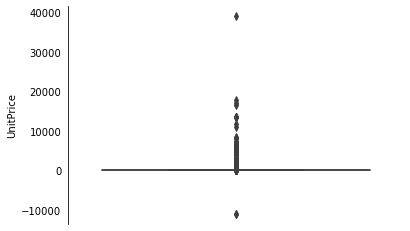

In [311]:
#Check Unit Price `s Distribution
sns.boxplot( y= 'UnitPrice' ,data =data)

It seems that there are values in UnitPrice column which are under 0

In [312]:
data[data['UnitPrice'] < 0 ]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Time,Month,Day,Year,Total
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,0.0,United Kingdom,14:51:00,August,Friday,2011,-11062.06
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,0.0,United Kingdom,14:52:00,August,Friday,2011,-11062.06


These are debt which are not required, so we remove them

There are some invoices which are debt, which we don't need in our analysis, these invoices are associated 
with description having word "dept". 

#### Now to remove rows that contains word "debt" or "DEBT" we can use below code

In [313]:
mask = data['Description'].str.contains('debt', case=False)
# Invert mask and use boolean indexing to filter out rows
data = data[~mask]

In [314]:
data = data[data['UnitPrice']>0] #filtering our data

In [315]:
#check the minimum
data['UnitPrice'].min()

0.001

Now let us also check for Quantity's distribution

<AxesSubplot:ylabel='Quantity'>

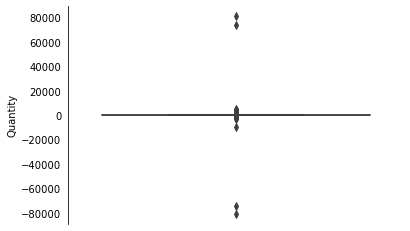

In [316]:
#Check Quantity's Distribution
sns.boxplot( y= 'Quantity' ,data =data)

This means that there are values in column Quantity which are under 0,
which happens when there is a cancelled purchase

In [317]:
data[data['Quantity'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Time,Month,Day,Year,Total
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,09:41:00,December,Wednesday,2010,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,09:49:00,December,Wednesday,2010,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,10:24:00,December,Wednesday,2010,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,10:24:00,December,Wednesday,2010,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,10:24:00,December,Wednesday,2010,-6.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,09:57:00,December,Friday,2011,-9.13
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,10:28:00,December,Friday,2011,-224.69
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,11:57:00,December,Friday,2011,-54.75
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,11:58:00,December,Friday,2011,-1.25


Now we can create a separate data frame for cancelled purchases

In [318]:
cancelled_purchases = data[data['Quantity'] < 0]

Now let's remove the cancelled purchases from our dataframe

In [319]:
data = data[data['Quantity'] > 0] #we modified our dataframe data to contain only purchased product

In [320]:
data['Quantity'].min() # check min to confirm for positive quantity

1

## Analysis

#### 1) What was the best month for sales?

In [321]:
#[['Total']] means that it will sum up on Total field and display as Month | Total
sales_2010 = data[data['Year']== 2010].groupby('Month').sum()[['Total']].reset_index()
sales_2011 = data[data['Year']== 2011].groupby('Month').sum()[['Total']].reset_index()

In [322]:
#let's get a list of years to know which years are present
years = data['Year'].unique() 

In [323]:
print(years)

[2010 2011]


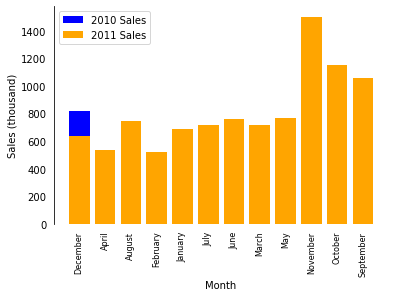

In [324]:
plt.bar(sales_2010["Month"],sales_2010['Total']/1000, label='2010 Sales', color='blue')
plt.bar(sales_2011["Month"],sales_2011['Total']/1000, label='2011 Sales', color='orange')
plt.xticks(rotation = 'vertical',size = 8)
plt.ylabel("Sales (thousand)")
plt.xlabel("Month")
plt.legend()
plt.show()
#we can use plt.savefig('my_plot.png') to save the plot, but remove plt.show()

Based on the analysis, it was found that the month with the highest total sales in 2011 was November, followed by October and September, while April and February had the least total sales. As for the year 2010, data was only available for December.

#### 2) What time should we display advertisements to maximize likelihood of customer's buying product?

In [325]:
#lets create a new column for hours, fetched from InvoiceDate field
data['Hour']=data['InvoiceDate'].dt.hour

In [326]:
BestTimeAdds = data.groupby('Hour').count().reset_index()

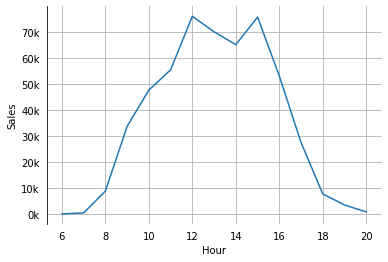

In [327]:
from matplotlib.ticker import StrMethodFormatter
plt.plot(BestTimeAdds['Hour'],BestTimeAdds['InvoiceNo']/1000)
plt.xlabel('Hour')
plt.ylabel('Sales')
plt.grid()
formatter = StrMethodFormatter('{x:.0f}k')
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

According to the data, the ideal time for this e-commerce company to run ads is between 12PM and 3PM as this 
time period yields the highest sales. 

It is possible that this is because customers are more likely to be available during their break times and are 
more likely to use their mobile devices or computers during these hours.

#### 3) What Products are most often sold together

In [328]:
soldTogether = data.groupby("InvoiceNo")['Description'].agg(lambda x : " , ".join(x)).reset_index()

In [329]:
soldTogether #we got items that are sold together, separated by ","

,InvoiceNo,Description
0,536365,"WHITE HANGING HEART T-LIGHT HOLDER , WHITE MET..."
1,536366,"HAND WARMER UNION JACK , HAND WARMER RED POLKA..."
2,536367,"ASSORTED COLOUR BIRD ORNAMENT , POPPY'S PLAYHO..."
3,536368,"JAM MAKING SET WITH JARS , RED COAT RACK PARIS..."
4,536369,BATH BUILDING BLOCK WORD
...,...,...
19954,581583,"LUNCH BAG RED RETROSPOT , 6 CHOCOLATE LOVE HEA..."
19955,581584,"RED FLOCK LOVE HEART PHOTO FRAME , 6 CHOCOLATE..."
19956,581585,"BLACK TEA TOWEL CLASSIC DESIGN , ASSORTED BOTT..."
19957,581586,"LARGE CAKE STAND HANGING STRAWBERY , SET OF 3..."


In [330]:
from itertools import combinations
from collections import Counter 

count = Counter()
for row in soldTogether['Description']:
    row_list = row.split(",")
    #item mostly solved together , here it shows 2 items sold together,we can change it to 3 
    #to show 3 items sold together and so on ...
    count.update(Counter(combinations(row_list,2)))

#most_common is method from collections 
for key,value in count.most_common(10):
    print(key,value)

(' KEY FOB ', ' KEY FOB ') 743
(' KEY FOB ', ' BACK DOOR  ') 544
(' KEY FOB ', ' SHED ') 511
(' JUMBO BAG PINK POLKADOT ', ' JUMBO BAG RED RETROSPOT ') 477
(' KEY FOB ', ' FRONT  DOOR  ') 455
(' GREEN REGENCY TEACUP AND SAUCER ', ' ROSES REGENCY TEACUP AND SAUCER  ') 443
('COFFEE', 'SUGAR ') 432
(' JUMBO SHOPPER VINTAGE RED PAISLEY ', ' JUMBO BAG RED RETROSPOT ') 427
(' SET 3 RETROSPOT TEA', 'COFFEE') 426
(' SET 3 RETROSPOT TEA', 'SUGAR ') 414


Analysis (Pair Products) : we can see that Key Fob are mostly sold with extra pair of Key Fob or with Back Door or with Shed. And so on...

FeedBack : we can recommend our customer in buying these items while purchasing for one item, this way we can enhance sales.

#### 4) What product sold the most ? 

In [331]:
soldMost = data.groupby('Description').sum()[['Quantity']].reset_index()

In [332]:
soldMost = soldMost.sort_values('Quantity',ascending = False ).head(5) #the data was big for products so i have
#just got results for top 10
soldMost

,Description,Quantity
2386,"PAPER CRAFT , LITTLE BIRDIE",80995
2051,MEDIUM CERAMIC TOP STORAGE JAR,78033
3933,WORLD WAR 2 GLIDERS ASSTD DESIGNS,54951
1815,JUMBO BAG RED RETROSPOT,48371
3843,WHITE HANGING HEART T-LIGHT HOLDER,37872


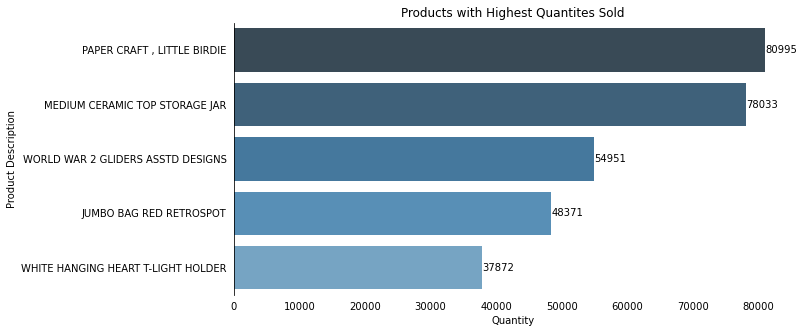

In [333]:
#Choosing Palette and reverse it
Palette = sns.color_palette('Blues_d')
Palette.reverse()

plt.figure(figsize = (10,5))
#Visualizing 
ax =sns.barplot(y = 'Description' , x= 'Quantity' , data = soldMost, palette = Palette)

#Data labels
ax.bar_label(ax.containers[0])

#Setting Title
plt.title('Products with Highest Quantites Sold')
plt.ylabel('Product Description')
plt.show()

Analysis : We can see that these items are sold the most from the company's website, out of them Paper Craft are sold most with approx 81k quantity

#### 4) Which countries have more customers?

In [334]:
custCountry = data['Country'].value_counts().reset_index(drop = False).head(10)
custCountry.columns = ['Country','Counts'] # renaming the columns

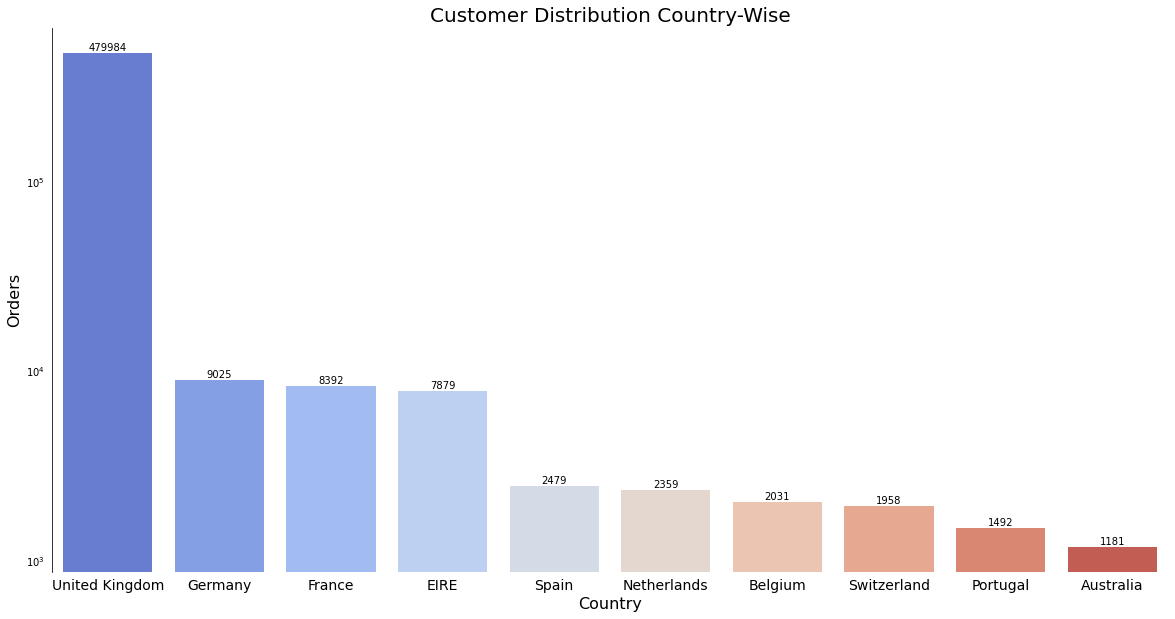

In [335]:
plt.figure(figsize = (20,10))
ax =sns.barplot(x= 'Country', y = 'Counts'  , data = custCountry, palette = 'coolwarm')
ax.bar_label(ax.containers[0])
plt.title("Customer Distribution Country-Wise",fontsize=20)
plt.ylabel("Orders",fontsize = 16)
plt.xlabel('Country',fontsize = 16)
plt.xticks(fontsize = 14)
plt.yscale('log')

#### 4) which day has more number of sales?

In [336]:
daySales = data.groupby('Day').count()[['InvoiceNo']].reset_index()
daySales.columns = ['Day','Sales']
daySales.sort_values(by='Day')

,Day,Sales
0,Friday,79666
1,Monday,92466
2,Sunday,62339
3,Thursday,100213
4,Tuesday,98726
5,Wednesday,91467


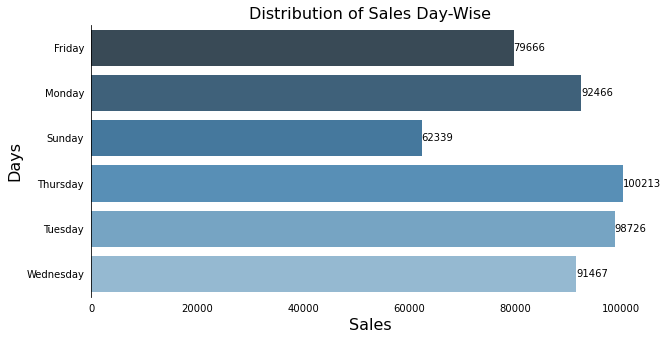

In [337]:
#Choosing Palette and reverse it
Palette = sns.color_palette('Blues_d')
Palette.reverse()

plt.figure(figsize = (10,5))
#Visualizing 
ax =sns.barplot(y = 'Day' , x= 'Sales' , data = daySales, palette = Palette)

#Data labels
ax.bar_label(ax.containers[0])

#Setting Title
plt.title('Distribution of Sales Day-Wise',fontsize = 16)
plt.ylabel('Days',fontsize = 16)
plt.xlabel('Sales',fontsize = 16)
plt.show()

### RMF Analysis

As a algorithm the RFM was used, for being an easy-to-understand model.

The term RFM comes from the function of three acronyms: Recency, Frequency, and Monetary, seeking to better understand the customer and verify when was his last purchase, how many times he has bought and how much he has spent with the company.

Recency(R) Days since the customer's last purchase Frequency(F) Number of products bought by the customer Monetarity(M) Total spent on purchases

Customer Score:

The customer score ranges from 1 to 5, where the higher this number, the better. This score is assigned for each acronym independently:

The more recent the customer's purchase the higher the Recency (R) score.

The more purchases the customer makes, the higher the Frequency score (F)

The more the customer spends on purchases, the higher the score the customer will have Monetarity(M) This definition of each score can be given through inference, i.e. some business definition or by quintile.

In [338]:
#Ignoring Cancel orders
copy[~copy['InvoiceNo'].str.contains('C' ,na = False)]

#Dropping Null values in Customer ID column
copy= copy.dropna(subset= ['CustomerID'])

#Make Checkoutprice Column
copy['CheckoutPrice'] = copy['UnitPrice'] * copy['Quantity']

#Ignoring Debts
copy =copy[copy['UnitPrice']>0]

#Dealing with datatypes
copy['InvoiceDate'] = pd.to_datetime(copy['InvoiceDate'])
copy['CustomerID'] = copy['CustomerID'].astype('int64')

In [339]:
recent_date = copy['InvoiceDate'].max()

In [341]:
#Set our data to rfm Analysis
rfm = copy.groupby('CustomerID').agg({'InvoiceDate' : lambda date : (recent_date - date.max()).days ,
                                      'InvoiceNo' : lambda num :num.nunique() ,
                                      'CheckoutPrice' : lambda CheckoutPrice :CheckoutPrice.sum()} )
rfm

,InvoiceDate,InvoiceNo,CheckoutPrice
CustomerID,,,
12346,325,2,0.00
12347,1,7,4310.00
12348,74,4,1797.24
12349,18,1,1757.55
12350,309,1,334.40
...,...,...,...
18280,277,1,180.60
18281,180,1,80.82
18282,7,3,176.60


In [342]:
rfm.columns = ['Recency' ,'Frequency' , 'Monetary']

In [343]:
#Ignore 0 in Monatery so we will not need those customers in our analysis 
rfm = rfm[rfm['Monetary']>0]

In [344]:
#Set Recency Score
rfm['Recency_Score'] = pd.qcut(rfm['Recency'] ,5 , labels= [5,4,3,2,1])

In [345]:
#Set Frequency Score
rfm['Frequency_Score'] = pd.qcut(rfm['Frequency'].rank(method ='first') ,5 , labels= [1,2,3,4,5])

In [346]:
#Set Monatry Score
rfm['Monetary_Score'] = pd.qcut(rfm['Monetary'] ,5 , labels= [1,2,3,4,5])

In [347]:
#Set RFM Score
rfm['RFM_Score'] = (rfm['Recency_Score'].astype(str) + rfm['Frequency_Score'].astype(str) + 
                    rfm['Monetary_Score'].astype(str) )

In [348]:
rfm

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score
CustomerID,,,,,,,
12347,1,7,4310.00,5,4,5,545
12348,74,4,1797.24,2,3,4,234
12349,18,1,1757.55,4,1,4,414
12350,309,1,334.40,1,1,2,112
12352,35,11,1545.41,3,5,4,354
...,...,...,...,...,...,...,...
18280,277,1,180.60,1,2,1,121
18281,180,1,80.82,1,2,1,121
18282,7,3,176.60,5,3,1,531


Segmentation calculation:

The calculation to know which segmentation the customer is in is given by averaging the F and R scores

I see that Monetary could be deceptive , So i will segment our customers on Recency and Frequency Scores

In [349]:
#Our Customer Segmentation
seg_map = {
    r'[1-2][1-2][1-5]': 'Hibernating',
    r'[1-2][3-4][1-5]': 'At risk',
    r'[1-2]5[1-5]' :'Cannot lose them',
    r'3[1-2][1-5]' : 'About to sleep',
    r'33[1-5]' : 'Need Attention',
    r'[3-4][4-5][1-5]' : 'Loyal Customers',
    r'[4-5][1-3][1-5]' : 'Good Potential',
    r'5[4-5][1-5]' : 'Champions',

}
rfm['Segment'] = rfm['RFM_Score'] .replace(seg_map ,regex =True)


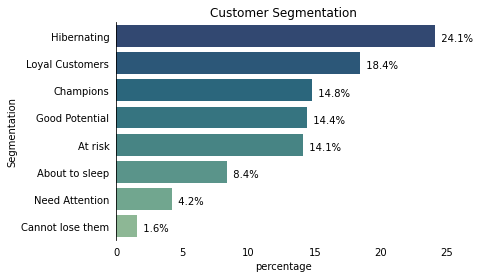

In [350]:
#Bar Plot for Our segments
Segments = (rfm['Segment'].value_counts(normalize=True)* 100).reset_index(name='percentage')
Segments = Segments.round(1)
b =sns.barplot(y='index',x='percentage', data=Segments, palette = 'crest_r')
for i, v in enumerate(Segments['percentage']):
    b.text(v,i+0.20,"  {:.1f}".format(v)+"%", color='black', ha="left")
    b.set_ylabel('Segmentation')
    b.set_title('Customer Segmentation')

In [351]:
rfm

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,Segment
CustomerID,,,,,,,,
12347,1,7,4310.00,5,4,5,545,Champions
12348,74,4,1797.24,2,3,4,234,At risk
12349,18,1,1757.55,4,1,4,414,Good Potential
12350,309,1,334.40,1,1,2,112,Hibernating
12352,35,11,1545.41,3,5,4,354,Loyal Customers
...,...,...,...,...,...,...,...,...
18280,277,1,180.60,1,2,1,121,Hibernating
18281,180,1,80.82,1,2,1,121,Hibernating
18282,7,3,176.60,5,3,1,531,Good Potential


### Findings

24.1% of our customers are in the hibernation segment and that for customers who have purchased from us a few times and the last time was a long time

18.4% of our customers are loyal and usually buys from us

14.8% of our customers are champions so we are their favourtie market

14.4% of our customers have good potential that refers to customers who have bought from us recently and have not buy many times

14.1% of our cutomeers are at risk segment so we must attract them again

8.4% of our customers are about to sleep and this segment of customers who last purchase from us for a fairly long time

4.2% of our customers are needing more attention to make them fall under Champions segment

1.6% of our customers can`t lost them and they purchased from us many times but last time was for a long time